# VISUM PT travel time ratio — preparation and analysis

This notebook prepares and analyzes public transport (PT) travel time ratios for the RVB VISUM project. It:

- Loads VISUM-derived zone/area/connector shapefiles and GTFS-based line geometries
- Reads PTV matrix files (usage, trips, transfers, car travel times)
- Enriches OD relations with PT metrics and zone attributes
- Builds filters for routing candidates and visual diagnostics (heatmaps, maps)
- Generates ReBus line buffers and intersects them with origin/destination zones

Inputs (repo-relative):
- `input/shapes/pt-data/*.SHP` zones, areas, connectors
- `input/mtx/*.mtx` PTV matrices (usage, trips, transfers, car_time)
- `input/gtfs-data/...` for GTFS routing context (optional)

Outputs (repo-relative examples):
- Derived Parquet/CSV under `output/`
- Diagnostic plots embedded in this notebook


## Contents

- 1. Setup and configuration
- 2. Data loading (zones, areas, connectors)
- 3. PTV matrices (usage, trips, transfers, car time)
- 4. Enrichment and merges (OD + attributes)
- 5. Filters and selections (routing candidates, heatmaps)
- 6. ReBus line buffers
- 7. Intersections and coverage (origins/destinations)
- 8. Plots and maps
- Appendix: How to run and publish

In [2]:
# -*- coding: utf-8 -*-
# Notebook cell: Read areas and connectors

import os
# Avoid PyGEOS/GEOS mismatch warnings and force Shapely backend
os.environ["USE_PYGEOS"] = "0"

import sys
from pathlib import Path

# Ensure we can import the local package `gtfs_routing` (sibling of this folder)
_nb_dir = Path.cwd().resolve()
_pkg_root = _nb_dir.parent  # src/pt-traveltimeratio
if str(_pkg_root) not in sys.path:
    sys.path.insert(0, str(_pkg_root))

import geopandas as gpd
import pandas as pd

from matrixconverters.read_ptv import ReadPTVMatrix

## 1. Setup and configuration

Environment, repo-relative paths, parameters, and small helper utilities used throughout the notebook.

In [3]:
# Configuration and parameters (safe defaults)
# This cell sets defaults only if variables are not already defined in the runtime.

from pathlib import Path
import os
import pandas as pd

# Debug/publish toggles
DEBUG = bool(os.environ.get('PT_DEBUG', '0') == '1') if 'DEBUG' not in globals() else DEBUG
PUBLISH_MODE = bool(os.environ.get('PT_PUBLISH', '0') == '1') if 'PUBLISH_MODE' not in globals() else PUBLISH_MODE

# Display settings for clean outputs
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Repo root detection
if 'repo_root' not in globals():
    here = Path.cwd()
    # Find the repo root by locating requirements.txt
    for p in [here] + list(here.parents):
        if (p / 'requirements.txt').exists():
            repo_root = p
            break
    else:
        repo_root = here

# Input/output directories
if 'shapes_dir' not in globals():
    shapes_dir = repo_root / 'input' / 'shapes' / 'pt-data'
if 'mtx_dir' not in globals():
    mtx_dir = repo_root / 'input' / 'mtx'
if 'output_dir' not in globals():
    output_dir = repo_root / 'output'
    output_dir.mkdir(parents=True, exist_ok=True)

# Common thresholds (used in filters)
usage_min = globals().get('usage_min', 0.90)
transfers_max_exclusive = globals().get('transfers_max_exclusive', 2)
trips_min = globals().get('trips_min', 5)
BUFFER_METERS = globals().get('BUFFER_METERS', 300.0)

# Column name conventions
ORIGIN_COL = globals().get('ORIGIN_COL', 'origins')
DEST_COL = globals().get('DEST_COL', 'destinations')
KEY_ORIGIN = globals().get('KEY_ORIGIN', 'NO')
KEY_DEST = globals().get('KEY_DEST', 'NO')
WKT_COL = globals().get('WKT_COL', 'geometry')
SRC_COL = globals().get('SRC_COL', 'LINENAME')

print(f"Repo root: {repo_root}")
print(f"Input dirs: shapes={shapes_dir}, mtx={mtx_dir}")
print(f"Output dir: {output_dir}")
print(f"Params: usage_min={usage_min}, transfers_max_exclusive={transfers_max_exclusive}, trips_min={trips_min}, BUFFER_METERS={BUFFER_METERS}")

Repo root: c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis
Input dirs: shapes=c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\shapes\pt-data, mtx=c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx
Output dir: c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\output
Params: usage_min=0.9, transfers_max_exclusive=2, trips_min=5, BUFFER_METERS=300.0


In [4]:
# Basisverzeichnis relativ zum Repo bestimmen (Notebook: kein __file__, daher über CWD gehen)
from pathlib import Path

cwd = Path.cwd().resolve()
# Suche nach Repo-Root: gehe nach oben bis Ordner mit 'input/shapes/pt-data' gefunden wird
repo_root = None
here = cwd
for _ in range(8):
    if (here / "input" / "shapes" / "pt-data").exists():
        repo_root = here
        break
    if here.parent == here:
        break
    here = here.parent

if repo_root is None:
    raise RuntimeError("Konnte Repo-Root nicht finden (input/shapes/pt-data fehlt). Bitte Notebook im Repo ausführen.")

shapes_dir = repo_root / "input" / "shapes" / "pt-data"
output_dir = repo_root / "output" / "scenario_V10_2025"

# Shapefiles (exakt nach Ordnerinhalt)
area_file = shapes_dir / "V10_2025_area.SHP"
zone_file = shapes_dir / "V10_2025_zone.SHP"
connector_file = shapes_dir / "V10_2025_connector.SHP"

In [5]:
# Helper functions for this notebook
import logging
import geopandas as gpd

logging.basicConfig(level=logging.INFO if not globals().get('DEBUG', False) else logging.DEBUG, format='[%(levelname)s] %(message)s')
log = logging.getLogger(__name__)

def debug(msg: str):
    if globals().get('DEBUG', False):
        log.debug(msg)

def ensure_projected(gdf: gpd.GeoDataFrame, target_epsg: int = 32632) -> gpd.GeoDataFrame:
    """Return GeoDataFrame in a projected CRS suitable for buffering (defaults to UTM32N)."""
    if gdf is None or gdf.empty:
        return gdf
    if gdf.crs is None:
        return gdf.set_crs(epsg=target_epsg)
    if gdf.crs.to_epsg() == target_epsg:
        return gdf
    try:
        return gdf.to_crs(epsg=target_epsg)
    except Exception as e:
        log.warning(f"CRS transform failed, keeping original CRS: {e}")
        return gdf

def unique_by_geometry(gdf: gpd.GeoDataFrame, geom_col: str = 'geometry') -> gpd.GeoDataFrame:
    """Drop duplicated geometries using WKB fingerprint; keep first occurrence."""
    if gdf is None or gdf.empty:
        return gdf
    tmp = gdf.copy()
    tmp['_wkb'] = tmp[geom_col].apply(lambda g: g.wkb if g is not None else b'')
    tmp = tmp.drop_duplicates(subset=['_wkb']).drop(columns=['_wkb'])
    return tmp

print("Helpers ready (debug, ensure_projected, unique_by_geometry)")

Helpers ready (debug, ensure_projected, unique_by_geometry)


In [6]:
# Helper: add connector counts (origin/destination) to a routing DataFrame
from typing import Optional

def add_connector_counts(
    routing_df: pd.DataFrame,
    connectors_gdf: gpd.GeoDataFrame,
    zones_with_endpoints: Optional[gpd.GeoDataFrame] = None,
    origin_col: str = 'origins',
    dest_col: str = 'destinations',
    zone_id_col: str = 'NO',
    connectors_zone_col: str = 'ZONENO'
) -> pd.DataFrame:
    """
    Add two integer columns to routing_df:
      - n_connectors_origin
      - n_connectors_destination
    Counts are derived from zones_with_endpoints['n_connectors'] if provided,
    otherwise by grouping connectors_gdf by its zone column.
    """
    if origin_col not in routing_df.columns or dest_col not in routing_df.columns:
        raise KeyError(f"routing_df must contain '{origin_col}' and '{dest_col}' columns")
    # Try zones_with_endpoints first
    if zones_with_endpoints is not None and 'n_connectors' in zones_with_endpoints.columns:
        zkey = zone_id_col if zone_id_col in zones_with_endpoints.columns else zones_with_endpoints.columns[0]
        counts_series = zones_with_endpoints.set_index(zkey)['n_connectors']
    else:
        ckey = connectors_zone_col if connectors_zone_col in connectors_gdf.columns else (
            'zone_id' if 'zone_id' in connectors_gdf.columns else None
        )
        if ckey is None:
            raise KeyError("connectors_gdf must have 'ZONENO' or 'zone_id' to group by zone")
        counts_series = connectors_gdf.groupby(ckey).size()
    counts_df = counts_series.rename('n_connectors').to_frame().reset_index().rename(columns={counts_series.index.name: 'zone_id_key'})

    out = routing_df.copy()
    out = out.merge(counts_df, left_on=origin_col, right_on='zone_id_key', how='left').rename(
        columns={'n_connectors': 'n_connectors_origin'}
    ).drop(columns=['zone_id_key'])
    out = out.merge(counts_df, left_on=dest_col, right_on='zone_id_key', how='left').rename(
        columns={'n_connectors': 'n_connectors_destination'}
    ).drop(columns=['zone_id_key'])

    out['n_connectors_origin'] = out['n_connectors_origin'].fillna(0).astype(int)
    out['n_connectors_destination'] = out['n_connectors_destination'].fillna(0).astype(int)
    return out

In [7]:
# Einlesen mit GeoPandas
print("Reading shapefiles...")

# Mit Encoding lesen (probier cp1252 oder latin1)
encoding = "latin1"
print("Reading shapefiles with encoding:", encoding)


gdf_area = gpd.read_file(area_file, encoding=encoding)
print(f"Areas loaded: {len(gdf_area)} records")

gdf_zones = gpd.read_file(zone_file, encoding=encoding)
print(f"Zones loaded: {len(gdf_zones)} records")

gdf_connectors = gpd.read_file(connector_file, encoding=encoding)
print(f"Connectors loaded: {len(gdf_connectors)} records")

# Optional: CRS prüfen
print("CRS (area):", gdf_area.crs)
print("CRS (zone):", gdf_zones.crs)
print("CRS (connector):", gdf_connectors.crs)

Reading shapefiles...
Reading shapefiles with encoding: latin1
Areas loaded: 20 records
Zones loaded: 2118 records


c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1.59' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 1.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '168.79' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 168.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: V

Connectors loaded: 8408 records
CRS (area): EPSG:32632
CRS (zone): EPSG:32632
CRS (connector): EPSG:32632


c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '8.92' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 8.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '3069.18' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 3069.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '6.44' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 6.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1814.01' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 1814.
  return ogr_read(
c:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\rvb\Lib\site-packages\pyogrio\raw.py:198: RuntimeWa

## 2. Data loading (zones, areas, connectors)

Read shapefiles for study area, zones, and connector lines. All paths are repo-relative and encoding is set to Latin-1 for legacy data.

In [8]:
# Filter alle PT-Connectors (FGV im TSYSSET)
FGV_connectors = gdf_connectors[
    gdf_connectors["TSYSSET"].str.contains("FGV", na=False)
]

print(f"Found PT connectors: {len(FGV_connectors)} of {len(gdf_connectors)} total")
print(FGV_connectors["TSYSSET"].unique())


Found PT connectors: 4245 of 8408 total
['FGV,Rad' 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,Pkw,Rad'
 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,OEVFUSS,Pkw,Rad' 'FGV,Pkw,Rad'
 'FGV,Lkw-k,OEVFUSS,Pkw,Rad' 'FGV,Lkw-k,Pkw,Rad'
 'FGV,Lkw-g,Lkw-k,Lkw-m,Pkw,Rad' 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,Pkw']


Connectors gefunden: 4 für ZONENO=310129901
Zonen gefunden: 1 mit NAME=BS Alt - Lehndorf 1


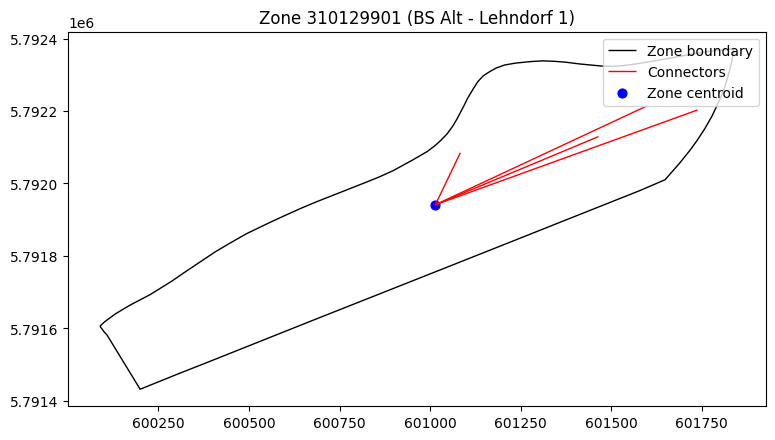

In [9]:
import matplotlib.pyplot as plt

zone_id = 310129901

# Filter connectors über ZONENO
conn_sub = FGV_connectors[FGV_connectors["ZONENO"] == zone_id]

# Filter zones über NO
zone_sub = gdf_zones[gdf_zones["NO"] == zone_id]

# Zonename für den Titel
zone_name = None
if not zone_sub.empty and "NAME" in zone_sub.columns:
    zone_name = zone_sub.iloc[0]["NAME"]

print(f"Connectors gefunden: {len(conn_sub)} für ZONENO={zone_id}")
print(f"Zonen gefunden: {len(zone_sub)} mit NAME={zone_name}")

# Plot
fig, ax = plt.subplots(figsize=(9, 9))

# Zone zeichnen
if not zone_sub.empty:
    zone_sub.boundary.plot(ax=ax, color="black", linewidth=1, label="Zone boundary")

# Connectors zeichnen
if not conn_sub.empty:
    conn_sub.plot(ax=ax, color="red", linewidth=1, label="Connectors")

# Optional: Centroid berechnen und plotten
if not zone_sub.empty:
    zone_sub.centroid.plot(ax=ax, color="blue", markersize=40, label="Zone centroid")

# Titel
title = f"Zone {zone_id}"
if zone_name:
    title += f" ({zone_name})"
ax.set_title(title)

ax.legend()
plt.show()


Computed far endpoints for 4 connectors


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_34180\4026306420.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zone_centroid: Point = zone_sub.geometry.unary_union.centroid


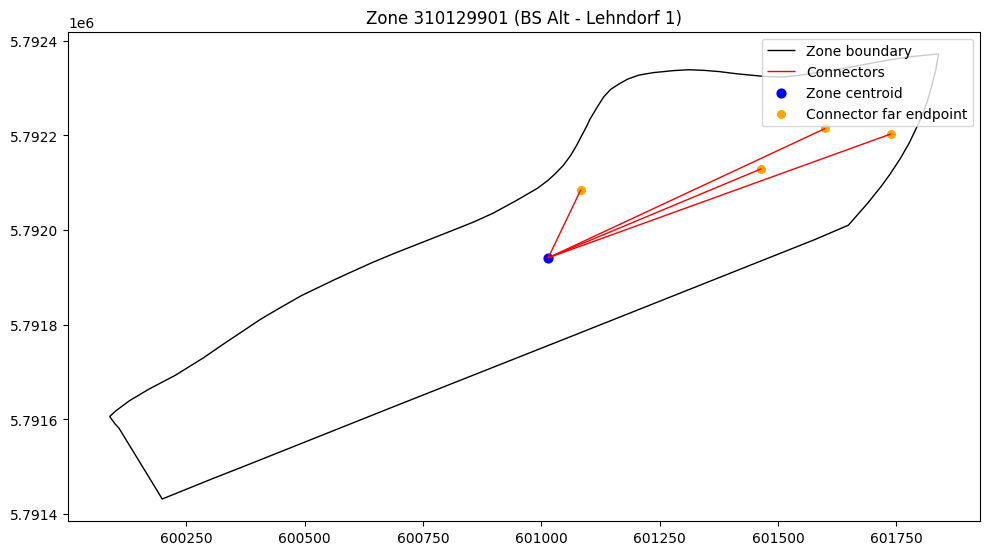

In [10]:
from shapely.geometry import Point, LineString, MultiLineString
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Annahme: zone_sub und conn_sub sind bereits gefiltert (eine Zone, nur PT-Connectors dieser Zone)
# CRS ist vereinheitlicht (z. B. EPSG:3857 oder dein Projekt-CRS)

# Referenzpunkt = Zonen-Centroid
if zone_sub.empty:
    raise ValueError("zone_sub is empty")
zone_centroid: Point = zone_sub.geometry.unary_union.centroid

def far_endpoint(geom, ref_pt: Point) -> Point:
    """Return the endpoint of a connector geometry that is farthest from ref_pt."""
    if geom is None or geom.is_empty:
        return None

    def endpts_ls(ls: LineString):
        c = list(ls.coords)
        return Point(c[0]), Point(c[-1])

    far_pt = None
    far_d = -1.0

    if isinstance(geom, LineString):
        p0, p1 = endpts_ls(geom)
        for p in (p0, p1):
            d = ref_pt.distance(p)
            if d > far_d:
                far_d, far_pt = d, p

    elif isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            p0, p1 = endpts_ls(ls)
            for p in (p0, p1):
                d = ref_pt.distance(p)
                if d > far_d:
                    far_d, far_pt = d, p
    else:
        # Falls mal ein anderer Typ auftaucht: auf den Centroid der Geometrie ausweichen
        p = geom.representative_point()
        far_pt = p

    return far_pt

# Endpunkte berechnen
end_points = []
rows = []
for idx, row in conn_sub.iterrows():
    geom = row.geometry
    p = far_endpoint(geom, zone_centroid)
    if p is not None:
        end_points.append(p)
        rows.append(row)

# GeoDataFrame der Endpunkte
gdf_endpts = gpd.GeoDataFrame(
    rows,
    geometry=end_points,
    crs=conn_sub.crs
)

print(f"Computed far endpoints for {len(gdf_endpts)} connectors")

# Plot: Zone, Connectors, Centroid, far Endpoints
fig, ax = plt.subplots(figsize=(10, 8))

# Zone
zone_sub.boundary.plot(ax=ax, color="black", linewidth=1, label="Zone boundary")

# Connectors
conn_sub.plot(ax=ax, color="red", linewidth=1, label="Connectors")

# Centroid
gpd.GeoSeries([zone_centroid], crs=zone_sub.crs).plot(ax=ax, color="blue", markersize=40, label="Zone centroid")

# Far endpoints
gdf_endpts.plot(ax=ax, color="orange", markersize=30, label="Connector far endpoint")

# Titel
zone_id = int(zone_sub.iloc[0]["NO"]) if "NO" in zone_sub.columns else None
zone_name = zone_sub.iloc[0]["NAME"] if "NAME" in zone_sub.columns else None
title = f"Zone {zone_id}" if zone_id is not None else "Zone"
if zone_name:
    title += f" ({zone_name})"
ax.set_title(title)

ax.legend()
plt.tight_layout()
plt.show()


In [13]:
# Requirements (only once):
# %pip install tqdm

import logging
from typing import List, Optional
from shapely.geometry import Point, LineString, MultiLineString
import geopandas as gpd
from tqdm import tqdm

# --------------------------------------------------------------------
# Logging
# --------------------------------------------------------------------
logging.basicConfig(level=print, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("pt-endpoints")

# --------------------------------------------------------------------
# Geometry helpers
# --------------------------------------------------------------------
def _far_endpoint(geom, ref_pt: Point) -> Optional[Point]:
    """
    Return the endpoint of a connector geometry that is farthest from ref_pt.
    Handles LineString and MultiLineString. Falls back to representative_point.
    """
    if geom is None or geom.is_empty:
        return None

    def endpts_ls(ls: LineString):
        c = list(ls.coords)
        return Point(c[0]), Point(c[-1])

    far_pt = None
    far_d = -1.0

    if isinstance(geom, LineString):
        p0, p1 = endpts_ls(geom)
        for p in (p0, p1):
            d = ref_pt.distance(p)
            if d > far_d:
                far_d, far_pt = d, p

    elif isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            p0, p1 = endpts_ls(ls)
            for p in (p0, p1):
                d = ref_pt.distance(p)
                if d > far_d:
                    far_d, far_pt = d, p
    else:
        # Fallback for unexpected geometry types
        far_pt = geom.representative_point()

    return far_pt

# --------------------------------------------------------------------
# Main function
# --------------------------------------------------------------------
def attach_far_endpoints_per_zone(
    zones: gpd.GeoDataFrame,
    connectors: gpd.GeoDataFrame,
    zone_id_col: str = "NO",          # zone id column in zones
    conn_zone_col: str = "ZONENO",    # zone id column in connectors
    endpoints_col: str = "connector_far_endpoints",
    n_connectors_col: str = "n_connectors",
) -> gpd.GeoDataFrame:
    """
    For each zone, find its connectors, compute far endpoints relative to the
    zone centroid, and store them as a list of Points in a new column.

    Returns a copy of `zones` with two new columns:
      - endpoints_col: list[Point] with one far endpoint per connector
      - n_connectors_col: int number of connectors considered
    """
    if zones.empty:
        raise ValueError("zones is empty")
    if connectors.empty:
        log.warning("connectors is empty; result columns will be empty lists.")

    # Make a copy to avoid mutating caller data
    zones_out = zones.copy()

    # Ensure a common CRS (project if needed)
    target_crs = zones_out.crs or connectors.crs
    if target_crs is None:
        raise ValueError("No CRS set on inputs. Please set CRS on zones/connectors.")

    if connectors.crs != target_crs:
        log.info("Projecting connectors to zones CRS.")
        connectors = connectors.to_crs(target_crs)

    # Precompute per-zone grouping for fast lookup
    log.info("Indexing connectors by zone id.")
    groups = connectors.groupby(conn_zone_col)

    # Prepare result columns
    zones_out[endpoints_col] = [[] for _ in range(len(zones_out))]
    zones_out[n_connectors_col] = 0

    # Iterate with progress bar
    log.info("Computing far endpoints per zone.")
    for i, row in tqdm(list(zones_out.iterrows()), total=len(zones_out)):
        zone_id = row[zone_id_col]
        geom = row.geometry
        if geom is None or geom.is_empty:
            # leave defaults (empty list, 0)
            continue

        centroid: Point = geom.centroid

        # Fetch connectors for this zone id
        try:
            conns_zone = groups.get_group(zone_id)
        except KeyError:
            # no connectors for this zone
            continue

        far_points: List[Point] = []
        for _, crow in conns_zone.iterrows():
            p = _far_endpoint(crow.geometry, centroid)
            if p is not None:
                far_points.append(p)

        zones_out.at[i, endpoints_col] = far_points
        zones_out.at[i, n_connectors_col] = len(far_points)

    log.info("Done computing endpoints.")
    return zones_out


In [14]:
zones_with_endpoints = attach_far_endpoints_per_zone(
    zones=gdf_zones,
    connectors=FGV_connectors,
    zone_id_col="NO",
    conn_zone_col="ZONENO",
    endpoints_col="connector_far_endpoints",
    n_connectors_col="n_connectors"
)


[INFO] Indexing connectors by zone id.
[INFO] Computing far endpoints per zone.
100%|██████████| 2118/2118 [00:00<00:00, 2384.33it/s]
[INFO] Done computing endpoints.


In [15]:
# Quick sanity check for one zone
zid = 310129901
row = zones_with_endpoints.loc[zones_with_endpoints["NO"] == zid].iloc[0]
print("zone:", zid, "n_connectors:", row["n_connectors"])
print("Endpoints:", row["connector_far_endpoints"])

zone: 310129901 n_connectors: 4
Endpoints: [<POINT (601599.594 5792214.543)>, <POINT (601083.482 5792084.906)>, <POINT (601464.824 5792129.438)>, <POINT (601738.397 5792202.934)>]


In [16]:
from shapely.geometry import MultiPoint
from shapely import wkt
import geopandas as gpd
from pathlib import Path

SRC_COL = "connector_far_endpoints"     # list[Point]
WKT_COL = "connector_far_end_wkt"       # str

# Ausgabeordner relativ zum Repo (nutzt repo_root aus vorheriger Zelle)
output_dir.mkdir(parents=True, exist_ok=True)
parquet_path = output_dir / "zones_with_endpoints.parquet"

def pack_points_to_wkt(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    z = gdf.copy()
    z[WKT_COL] = z[SRC_COL].apply(
        lambda pts: MultiPoint(pts).wkt if pts else None
    )
    return z.drop(columns=[SRC_COL])

def unpack_wkt_to_points(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    z = gdf.copy()
    def _to_pts(s):
        if not s:
            return []
        mp = wkt.loads(s)
        return list(mp.geoms)  # list[Point]
    z[SRC_COL] = z[WKT_COL].apply(_to_pts)
    return z

# speichern
z_out = pack_points_to_wkt(zones_with_endpoints)
z_out.to_parquet(parquet_path, index=False)
print("Saved:", parquet_path)

Saved: C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\output\scenario_V10_2025\zones_with_endpoints.parquet


In [17]:
parquet_path = repo_root / "output" / "scenario_V10_2025" / "zones_with_endpoints.parquet"
zones_with_endpoints_import = gpd.read_parquet(parquet_path)


In [18]:
class GTFSRouteLookup:
    def __init__(self, gtfs_zip_path):
        self.routes = self._load_routes(gtfs_zip_path)

    GTFS_ROUTE_TYPES = {
        0: "Tram / Light Rail",
        1: "Subway / Metro",
        2: "Rail",
        3: "Bus",
        4: "Ferry",
        5: "Cable Car",
        6: "Gondola / Suspended Cable Car",
        7: "Funicular"}

    def _load_routes(self, gtfs_zip_path):
        return pd.read_csv(gtfs_zip_path)[["route_id", "route_short_name", "route_type"]]

    def get_route_info(self, route_id):
        match = self.routes[self.routes["route_id"] == route_id]
        if not match.empty:
            return match.iloc[0]["route_short_name"], self.GTFS_ROUTE_TYPES.get(match.iloc[0]["route_type"], "Unknown")
        return None, None

In [19]:
from gtfs_routing.transit_router import TransitRouter

csv_path = repo_root / "input" / "gtfs-data" / "2025(V10)" / "routes.txt"

router = TransitRouter()

gtfs_route_lookup = GTFSRouteLookup(csv_path)
routes = pd.read_csv(csv_path)

In [20]:
lineRoutes = gpd.read_file(shapes_dir / "V10_2025_lineRoute.SHP", encoding="latin1")
lineRoutes

,TSYSCODE,LINENAME,NAME,DIRECTIO~1,STOPSSER~2,LENGTH,LINKRUNT~3,NUMSERVI~4,SERVICEK~5,PASSKMTR~6,PTRIPSUN~7,ANZ_HALT~8,ANZ_HALT~9,ANZ_HAL~10,ANZ_HAL~11,ANZ_HAL~12,ANZ_HAL~13,ANZ_HAL~14,ANZ_HAL~15,LAENGE_~16,LAENGE_~17,LAENGE_~18,LAENGE_~19,LAENGE_~20,LAENGE_~21,LAENGE_~22,LAENGE_~23,SERVICE~24,SERVICE~25,SERVICE~26,SERVICE~27,SERVICE~28,SERVICE~29,SERVICE~30,SERVICE~31,geometry
0,TRAM,100_1,1_1031,H,5,"1,375km",1min 27s,0,"0,000km","0,000km",0,0,0,0,0,0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (623930.925 5707438.07, 623978.726 ..."
1,TRAM,100_1,1_1031,R,7,"2,069km",2min 14s,0,"0,000km","0,000km",0,0,0,0,0,0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (624819.215 5708683.096, 624819.437..."
2,TRAM,100_1,1_1031_1,H,10,"3,093km",3min 23s,0,"0,000km","0,000km",0,0,0,0,0,0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (624213.593 5706270.202, 624249.977..."
3,TRAM,100_1,1_1031_1,R,10,"3,265km",3min 32s,0,"0,000km","0,000km",0,0,0,0,0,0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (624819.215 5708683.096, 624819.437..."
4,TRAM,100_10,10_1031,H,5,"4,470km",0h,0,"0,000km","0,000km",0,0,0,0,0,0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (623852.385 5716396.268, 623870.189..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32903,ReBus,13_860,406502978_406502978_24784_406502978_24784_24784,R,21,"18,006km",21min 33s,0,"0,000km","0,000km",0,0,0,0,0,21,0,0,0,None,None,None,None,"19,790km",None,None,None,None,None,None,None,"39,581km",None,None,None,"LINESTRING (597981.81 5764410.948, 597983.379 ..."
32904,ReBus,13_860,406502986_406502986_24792,H,27,"25,417km",30min 26s,0,"0,000km","0,000km",0,0,4,0,0,23,0,0,0,None,"4,196km",None,None,"23,445km",None,None,None,None,"8,393km",None,None,"46,889km",None,None,None,"LINESTRING (597739.395 5752092.608, 597830.58 ..."
32905,ReBus,13_860,406502990_406502990_24796_406502990_24796_24796,H,20,"22,878km",26min 5s,0,"0,000km","0,000km",0,0,0,0,0,20,0,0,0,None,None,None,None,"23,718km",None,None,None,None,None,None,None,"71,155km",None,None,None,"LINESTRING (601865.99 5751146.437, 601870.575 ..."
32906,ReBus,13_860,406502997_406502997_406502997,H,28,"26,730km",31min 56s,0,"0,000km","0,000km",0,0,4,0,0,24,0,0,0,None,"4,196km",None,None,"24,887km",None,None,None,None,"8,393km",None,None,"49,774km",None,None,None,"LINESTRING (597739.395 5752092.608, 597830.58 ..."


In [23]:
# Read PTV matrices (repo-relative, English variable names)
from pathlib import Path
import shutil
import re

# Ensure repo_root and mtx_dir are defined (set earlier in the notebook)
try:
    _ = repo_root
except NameError:
    # Derive repo_root from CWD as in earlier cells
    cwd = Path.cwd().resolve()
    repo_root = cwd
    for _ in range(8):
        if (repo_root / "input" / "shapes" / "pt-data").exists():
            break
        if repo_root.parent == repo_root:
            break
        repo_root = repo_root.parent

mtx_dir = repo_root / "input" / "mtx" / "backup"

# Matrix files (English variable names)
mtx_pt_trips = mtx_dir / "3 OEV PV.mtx"
mtx_usage_rebus = mtx_dir / "Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx"
mtx_pt_transfers = mtx_dir / "173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx"
# mtx_car_time = mtx_dir / "221 RZ Pkw präp.mtx"
mtx_car_time = mtx_dir / "TTM_PKW_präp.mtx"  # Using OEV travel time as a proxy for car time

print("Matrix files (repo-relative):")
print("- PT trips:", mtx_pt_trips)
print("- Usage (ReBus):", mtx_usage_rebus)
print("- PT transfers (MUH):", mtx_pt_transfers)
print("- Car time (RZ Pkw):", mtx_car_time)

# Existence checks
for p in [mtx_pt_trips, mtx_usage_rebus, mtx_pt_transfers, mtx_car_time]:
    print(f"exists={p.exists()} size={(p.stat().st_size if p.exists() else 'n/a')} -> {p}")

# Read with ReadPTVMatrix if available
try:
    _ = ReadPTVMatrix
except NameError:
    raise RuntimeError("ReadPTVMatrix is not available in this kernel. Please import/define it before reading matrices.")

# Create datasets (use English dataset names)

pt_trips_matrix = ReadPTVMatrix(filename=str(mtx_pt_trips))
usage_rebus_matrix = ReadPTVMatrix(filename=str(mtx_usage_rebus))
pt_transfers_matrix = ReadPTVMatrix(filename=str(mtx_pt_transfers))
car_time_matrix = ReadPTVMatrix(filename=str(mtx_car_time))


Matrix files (repo-relative):
- PT trips: C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\3 OEV PV.mtx
- Usage (ReBus): C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx
- PT transfers (MUH): C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx
- Car time (RZ Pkw): C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\TTM_PKW_präp.mtx
exists=True size=34435421 -> C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\3 OEV PV.mtx
exists=True size=16470671 -> C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx
exists=True size=25409795 -> C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\mtx\backup\173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx
exists=True size=35343196 -> C:\Users\bienzeisler\Documents\

## 6. ReBus line buffers

Load line routes, filter to ReBus, and create dissolved buffers per LINENAME (default 300 m). Ensure projected CRS before buffering.

In [24]:
# Convert PTV matrices to Pandas DataFrames (English variables, consistent schema)
import xarray as xr

def _matrix_dataarray(ds: xr.Dataset):
    """Return the primary matrix DataArray from a dataset (fallback to first data var)."""
    if "matrix" in ds:
        return ds["matrix"]
    # fallback: first variable
    try:
        name = next(iter(ds.data_vars))
        return ds[name]
    except StopIteration:
        raise ValueError("PTV matrix dataset contains no data variables.")

# Extract DataArrays
da_pt_trips = _matrix_dataarray(pt_trips_matrix)           # 3 OEV PV.mtx
da_usage_rebus = _matrix_dataarray(usage_rebus_matrix)     # 3000061 PS(ReBus) ...
da_pt_transfers = _matrix_dataarray(pt_transfers_matrix)   # 173 MUH ...
da_car_time = _matrix_dataarray(car_time_matrix)           # 221 RZ Pkw präp.mtx

# To DataFrames (origins, destinations, value)
df_pt_trips = da_pt_trips.to_dataframe(name="value").reset_index()
df_usage_rebus = da_usage_rebus.to_dataframe(name="value").reset_index()
df_pt_transfers = da_pt_transfers.to_dataframe(name="value").reset_index()
df_car_time = da_car_time.to_dataframe(name="value").reset_index()

# Optional: set index for fast lookup on time matrix
if set(["origins", "destinations"]).issubset(df_car_time.columns):
    df_car_time.set_index(["origins", "destinations"], inplace=True)

print("DataFrames created:")
print(f"- df_pt_trips: {df_pt_trips.shape} (from {mtx_pt_trips.name})")
print(f"- df_usage_rebus: {df_usage_rebus.shape} (from {mtx_usage_rebus.name})")
print(f"- df_pt_transfers: {df_pt_transfers.shape} (from {mtx_pt_transfers.name})")
print(f"- df_car_time: {df_car_time.shape} (from {mtx_car_time.name})")

DataFrames created:
- df_pt_trips: (4752400, 3) (from 3 OEV PV.mtx)
- df_usage_rebus: (4752400, 3) (from Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx)
- df_pt_transfers: (4752400, 3) (from 173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx)
- df_car_time: (4752400, 1) (from TTM_PKW_präp.mtx)


In [25]:
# Rename 'value' to an English column name for transfers
transfers_df = df_pt_transfers.rename(columns={"value": "pt_transfers"})[["origins", "destinations", "pt_transfers"]]

# Merge onto usage (left join on origins/destinations)
df_usage_rebus = df_usage_rebus.merge(transfers_df, how="left", on=["origins", "destinations"])

matched = df_usage_rebus["pt_transfers"].notna().sum()
missing = df_usage_rebus["pt_transfers"].isna().sum()
print("Merged PT transfers into df_usage_rebus")
print("- Matched OD pairs:", matched)
print("- Missing OD pairs:", missing)

Merged PT transfers into df_usage_rebus
- Matched OD pairs: 4752400
- Missing OD pairs: 0


In [26]:
# Enrich usage (ReBus) OD matrix with PT transfers, PT trips, names and geometries (English)
import pandas as pd

# Preconditions
need = ["df_usage_rebus", "df_pt_transfers", "df_pt_trips", "gdf_zones"]
missing = [n for n in need if n not in globals()]
if missing:
    raise NameError(f"Missing required variables: {missing}. Run previous cells first.")

def _coalesce_columns(df: pd.DataFrame, base: str) -> pd.DataFrame:
    """Coalesce columns like base, base_x, base_y,... into a single 'base' and drop others."""
    candidates = [c for c in df.columns if c == base or c.startswith(base + "_")]
    if not candidates:
        return df
    series = None
    for c in candidates:
        if series is None:
            series = df[c]
        else:
            series = series.combine_first(df[c])
    df[base] = series
    drop_cols = [c for c in candidates if c != base]
    return df.drop(columns=drop_cols, errors="ignore")

# Start from a copy to avoid mutating the original
df_enriched = df_usage_rebus.copy()

# Ensure English value column for usage
if "usage_rebus" not in df_enriched.columns:
    if "value" in df_enriched.columns:
        df_enriched = df_enriched.rename(columns={"value": "usage_rebus"})
    else:
        raise KeyError("Neither 'usage_rebus' nor 'value' found in df_usage_rebus.")

# Merge PT transfers (rename to 'pt_transfers')
transfers_df = df_pt_transfers.rename(columns={"value": "pt_transfers"})[["origins", "destinations", "pt_transfers"]]
df_enriched = df_enriched.merge(transfers_df, how="left", on=["origins", "destinations"])
df_enriched = _coalesce_columns(df_enriched, "pt_transfers")
matched_transfers = df_enriched["pt_transfers"].notna().sum()
missing_transfers = df_enriched["pt_transfers"].isna().sum()
print("Merged PT transfers:", matched_transfers, "matched;", missing_transfers, "missing")

# Merge PT trips (rename to 'pt_trips')
trips_df = df_pt_trips.rename(columns={"value": "pt_trips"})[["origins", "destinations", "pt_trips"]]
df_enriched = df_enriched.merge(trips_df, how="left", on=["origins", "destinations"])
df_enriched = _coalesce_columns(df_enriched, "pt_trips")
matched_trips = df_enriched["pt_trips"].notna().sum()
missing_trips = df_enriched["pt_trips"].isna().sum()
print("Merged PT trips:", matched_trips, "matched;", missing_trips, "missing")

# Determine zone ref GeoDataFrame
gdf_ref = globals().get("gdf_reduced", None)
if gdf_ref is None:
    gdf_ref = gdf_zones[["NO", "NAME", "geometry"]]

# Merge origin name
df_enriched = df_enriched.merge(gdf_ref[["NO", "NAME"]], left_on="origins", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"NAME": "origin_name"}).drop(columns=["NO"], errors="ignore")

# Merge destination name
df_enriched = df_enriched.merge(gdf_ref[["NO", "NAME"]], left_on="destinations", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"NAME": "destination_name"}).drop(columns=["NO"], errors="ignore")

# Merge origin geometry
df_enriched = df_enriched.merge(gdf_ref[["NO", "geometry"]], left_on="origins", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"geometry": "origin_geometry"}).drop(columns=["NO"], errors="ignore")

# Merge destination geometry
df_enriched = df_enriched.merge(gdf_ref[["NO", "geometry"]], left_on="destinations", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"geometry": "destination_geometry"}).drop(columns=["NO"], errors="ignore")

# Clean up any residual duplicate helper columns (including any *_x/*_y from name/geometry merges)
drop_candidates = [c for c in df_enriched.columns if c.endswith("_x") or c.endswith("_y")]
df_enriched = df_enriched.drop(columns=drop_candidates, errors="ignore")

print("Enriched usage DataFrame shape:", df_enriched.shape)
# Make the enriched frame available under a clear name
df_usage_rebus_enriched = df_enriched
df_usage_rebus_enriched.head()

Merged PT transfers: 4752400 matched; 0 missing
Merged PT trips: 4752400 matched; 0 missing
Enriched usage DataFrame shape: (4752400, 9)


,origins,destinations,usage_rebus,pt_transfers,pt_trips,origin_name,destination_name,origin_geometry,destination_geometry
0,310101901,310101901,0.000000,99999.000000,25.499336,BS Stadtkern 6,BS Stadtkern 6,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603845.77 5791532.412, 603828.391 57..."
1,310101901,310101902,0.199772,0.002856,22.912864,BS Stadtkern 6,BS Stadtkern 9,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603798.46 5791316.225, 603740.225 57..."
2,310101901,310101903,0.176499,0.020194,21.427874,BS Stadtkern 6,BS Stadtkern 13,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603829.121 5790964.967, 603769.226 5..."
3,310101901,310101904,0.024029,0.226925,8.767568,BS Stadtkern 6,BS Stadtkern 17,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603455.156 5791018.867, 603492.946 5..."
4,310101901,310101905,0.160468,0.002142,26.381425,BS Stadtkern 6,BS Stadtkern 15,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603968.386 5791312.927, 603981.628 5..."


In [27]:
gdf_destination = gpd.GeoDataFrame(
    df_usage_rebus_enriched, 
    geometry=df_usage_rebus_enriched['destination_geometry'], 
    crs=gdf_ref.crs
)

gdf_origin = gpd.GeoDataFrame(
    df_usage_rebus_enriched, 
    geometry=df_usage_rebus_enriched['origin_geometry'], 
    crs=gdf_ref.crs
)


In [28]:
# Build routing GeoDataFrame based on thresholds (usage_rebus, pt_transfers, pt_trips)
import pandas as pd

# Source frame
try:
    base_gdf = df_usage_rebus_enriched.copy()
except NameError:
    raise NameError("gdf_destination_filtered is not defined. Run the filtering step that creates it first.")

required_cols = ["usage_rebus", "pt_transfers", "pt_trips"]
missing_cols = [c for c in required_cols if c not in base_gdf.columns]

# If any required columns are missing, try to merge them from the enriched OD DataFrame
if missing_cols:
    if 'df_usage_rebus_enriched' in globals():
        join_keys = ["origins", "destinations"]
        if all(k in base_gdf.columns for k in join_keys):
            add_cols = join_keys + [c for c in missing_cols if c in df_usage_rebus_enriched.columns]
            if len(add_cols) >= 3:  # at least origins,destinations, and one metric
                base_gdf = base_gdf.merge(df_usage_rebus_enriched[add_cols], how="left", on=join_keys)
                # Recompute missing after merge
                missing_cols = [c for c in required_cols if c not in base_gdf.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns in df_usage_rebus_enriched: {missing_cols}. Ensure enrichment step ran and columns exist.")

# Thresholds
usage_min = 0.90
transfers_max_exclusive = 2
trips_min = 5

# Apply filter
mask = (base_gdf["usage_rebus"] >= usage_min) & (base_gdf["pt_transfers"] < transfers_max_exclusive) & (base_gdf["pt_trips"] >= trips_min)
gdf_routing = base_gdf.loc[mask].copy()

print("Routing filter applied:")
print(f"- Total rows in gdf_destination_filtered: {len(base_gdf)}")
print(f"- Selected rows (usage_rebus >= {usage_min}, pt_transfers < {transfers_max_exclusive}, pt_trips >= {trips_min}): {len(gdf_routing)}")

# Peek at result
gdf_routing.head()

Routing filter applied:
- Total rows in gdf_destination_filtered: 4752400
- Selected rows (usage_rebus >= 0.9, pt_transfers < 2, pt_trips >= 5): 423


,origins,destinations,usage_rebus,pt_transfers,pt_trips,origin_name,destination_name,origin_geometry,destination_geometry
841,310101901,315700717,1.0,0.0,5.095936,BS Stadtkern 6,Vechelde Wetlenstedt 17,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((597393.972 5791944.752, 597392.989 5..."
915,310101901,315803716,1.0,0.0,15.155674,BS Stadtkern 6,WB Krz Holz 16,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((605170.562 5783478.749, 605166.451 5..."
925,310101901,315803726,1.0,0.0,9.444248,BS Stadtkern 6,WB Schwedenschanze 26,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((604693.828 5783515.517, 604698.571 5..."
926,310101901,315803727,1.0,0.0,8.443918,BS Stadtkern 6,WB Schwedenschanze 27,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((605359.405 5780689.921, 605299.51 57..."
3095,310101902,315803716,1.0,0.0,15.275213,BS Stadtkern 9,WB Krz Holz 16,"POLYGON ((603798.46 5791316.225, 603740.225 57...","POLYGON ((605170.562 5783478.749, 605166.451 5..."


### 5.1 Add connector counts per origin/destination

For each OD in `df_routing`, attach the number of available connectors at the origin and at the destination. This uses `zones_with_endpoints` if present, otherwise it derives counts directly from `FGV_connectors` grouped by zone id.

In [30]:
# Compute connector counts for origin and destination zones and join into df_routing
import pandas as pd
import numpy as np

# Preconditions
assert 'gdf_routing' in globals() and not gdf_routing.empty, "df_routing is not available. Run the routing filter cell first."
assert 'FGV_connectors' in globals() and not FGV_connectors.empty, "FGV_connectors is missing/empty. Load connectors earlier."

# Resolve zone ID column names used in df_routing
orig_col = ORIGIN_COL if ORIGIN_COL in gdf_routing.columns else 'origins'
dest_col = DEST_COL if DEST_COL in gdf_routing.columns else 'destinations'

if orig_col not in gdf_routing.columns or dest_col not in gdf_routing.columns:
    raise KeyError(f"df_routing must contain '{ORIGIN_COL}'/'{DEST_COL}' or 'origins'/'destinations'. Got: {list(gdf_routing.columns)}")

# Build connector counts per zone
# Preferred: use zones_with_endpoints if available and has 'n_connectors'
use_endpoints = 'zones_with_endpoints' in globals() and zones_with_endpoints is not None and 'n_connectors' in zones_with_endpoints.columns
if use_endpoints:
    zone_key = 'NO' if 'NO' in zones_with_endpoints.columns else KEY_ORIGIN
    counts_series = zones_with_endpoints.set_index(zone_key)['n_connectors']
else:
    # Fallback: group connectors by their zone field
    conn_zone_col = 'ZONENO' if 'ZONENO' in FGV_connectors.columns else 'zone_id'
    if conn_zone_col not in FGV_connectors.columns:
        raise KeyError("FGV_connectors must have a 'ZONENO' or 'zone_id' column for grouping.")
    counts_series = FGV_connectors.groupby(conn_zone_col).size()

# Prepare a DataFrame for merging
counts_df = counts_series.rename('n_connectors').to_frame().reset_index()
counts_df = counts_df.rename(columns={counts_df.columns[0]: 'zone_id_key'})

# Left-join counts for origin and destination separately
left = gdf_routing
left = left.merge(counts_df, left_on=orig_col, right_on='zone_id_key', how='left')
left = left.rename(columns={'n_connectors': 'n_connectors_origin'})
left = left.drop(columns=['zone_id_key'])

left = left.merge(counts_df, left_on=dest_col, right_on='zone_id_key', how='left')
left = left.rename(columns={'n_connectors': 'n_connectors_destination'})
left = left.drop(columns=['zone_id_key'])

# Fill NaNs with zeros (zones without connectors)
left['n_connectors_origin'] = left['n_connectors_origin'].fillna(0).astype(int)
left['n_connectors_destination'] = left['n_connectors_destination'].fillna(0).astype(int)

# Update df_routing
df_routing = left

print("Added connector counts: columns ['n_connectors_origin','n_connectors_destination']")
print(df_routing[['n_connectors_origin','n_connectors_destination']].describe())

Added connector counts: columns ['n_connectors_origin','n_connectors_destination']
       n_connectors_origin  n_connectors_destination
count           423.000000                423.000000
mean              2.565012                  2.468085
std               1.995233                  1.835226
min               1.000000                  1.000000
25%               1.000000                  1.000000
50%               2.000000                  2.000000
75%               4.000000                  4.000000
max              15.000000                  8.000000


## 4. Enrichment and merges (OD + attributes)

Merge PT usage with transfers/trips and attach zone names/geometries; coalesce duplicate columns and standardize English names.

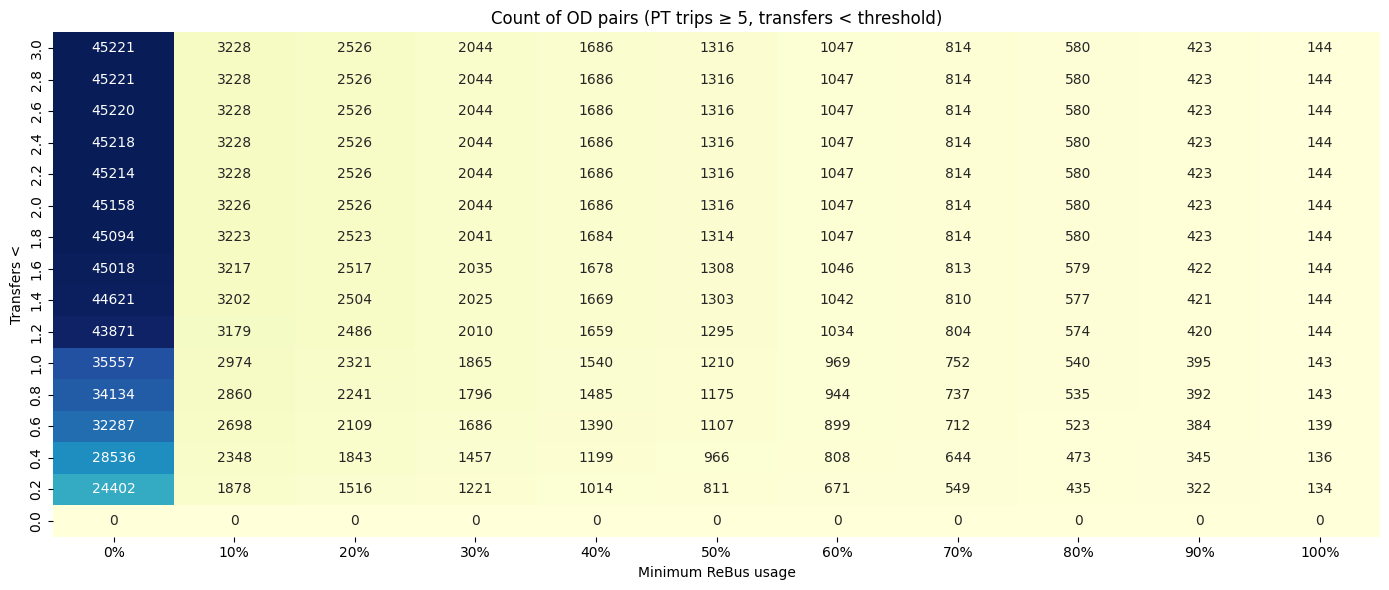

Exact count for usage_rebus ≥ 0.90, pt_transfers < 2, pt_trips ≥ 5: 3226


In [31]:
# Heatmap of remaining OD relations with consistent filters (English columns)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use the enriched OD frame
base = df_usage_rebus_enriched.copy()

# Optional: ensure one row per OD pair to avoid double counting from joins
deduplicate_by_od = True
if deduplicate_by_od and set(["origins","destinations"]).issubset(base.columns):
    base = base.drop_duplicates(subset=["origins","destinations"])

# Thresholdspip
usage_thresholds = np.round(np.arange(0.0, 1.01, 0.1), 2)
transfer_thresholds = np.round(np.arange(0, 3.1, 0.2), 2)
trips_threshold = 5
strict_transfers = True  # set to True to use '<'; set to False to use '≤'

# Build results
rows = []
for u in usage_thresholds:
    for t in transfer_thresholds:
        mask = (base["usage_rebus"] >= u) & \
                ((base["pt_transfers"] < t) if strict_transfers else (base["pt_transfers"] <= t)) & \
                (base["pt_trips"] >= trips_threshold)
        count = int(mask.sum())
        rows.append({
            "Transfers op": "<" if strict_transfers else "≤",
            "Transfers thr": t,
            "Usage ≥ %": int(u * 100),
            "Count": count,
        })

df_result = pd.DataFrame(rows)

# Pivot table for heatmap
y_label = f"Transfers {rows[0]['Transfers op']}"
heatmap_data = df_result.pivot(index=["Transfers thr"], columns=["Usage ≥ %"], values="Count").sort_index(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
ax.set_xticklabels([f"{int(label.get_text())}%" for label in ax.get_xticklabels()])
plt.title(f"Count of OD pairs (PT trips ≥ {trips_threshold}, transfers {rows[0]['Transfers op']} threshold)")
plt.ylabel(y_label)
plt.xlabel("Minimum ReBus usage")
plt.tight_layout()
plt.show()

# Exact check for your target thresholds (should match gdf_routing selection)
target_usage = 0.10
target_transfers = 2.0
target_trips = 5
mask_target = (base["usage_rebus"] >= target_usage) & (base["pt_transfers"] < target_transfers) & (base["pt_trips"] >= target_trips)
print("Exact count for usage_rebus ≥ 0.90, pt_transfers < 2, pt_trips ≥ 5:", int(mask_target.sum()))

## 5. Filters and selections (routing candidates, heatmaps)

Apply thresholds (usage ≥ usage_min, transfers < transfers_max_exclusive, trips ≥ trips_min). Visualize distributions and build a heatmap of OD coverage; ensure de-duplication of OD if needed.

In [32]:
# ==== Parameter ====
target_usage = 0.10
target_transfers = 2.0
target_trips = 5
strict_transfers = True  # oder False je nach Logik

# ==== Filter definieren ====
mask = (
    (df_usage_rebus_enriched["usage_rebus"] >= target_usage) &
    ((df_usage_rebus_enriched["pt_transfers"] < target_transfers) 
     if strict_transfers else 
     (df_usage_rebus_enriched["pt_transfers"] <= target_transfers)) &
    (df_usage_rebus_enriched["pt_trips"] >= target_trips)
)

# ==== Gefiltertes DataFrame ====
df_usage_filtered = df_usage_rebus_enriched[mask].copy()


In [33]:
# Load line routes shapefile, filter ReBus, and add 'line_number' (English variables)
import geopandas as gpd

# Use shapes_dir from earlier (repo_root/input/shapes/pt-data)
line_routes_file = shapes_dir / "V10_2025_lineRoute.SHP"
print("Reading line routes:", line_routes_file)
gdf_lines = gpd.read_file(line_routes_file, encoding="latin1")
print("Total line routes:", len(gdf_lines))

# Filter to ReBus only
gdf_rebus_lines = gdf_lines[gdf_lines["TSYSCODE"] == "ReBus"].copy()
print("ReBus lines:", len(gdf_rebus_lines))

# Add a 'line_number' column parsed from LINENAME after the first underscore
# Example: LINENAME like 'ReBus_123' -> line_number = '123'
gdf_rebus_lines["line_number"] = gdf_rebus_lines["LINENAME"].astype(str).str.split("_").str[1].fillna("")

# Quick preview of relevant columns
cols_preview = [c for c in ["LINENAME", "line_number", "TSYSCODE"] if c in gdf_rebus_lines.columns]
gdf_rebus_lines[cols_preview].head()

Reading line routes: C:\Users\bienzeisler\Documents\GitHub\RVB-VISUM-analysis\input\shapes\pt-data\V10_2025_lineRoute.SHP
Total line routes: 32908
ReBus lines: 1075


,LINENAME,line_number,TSYSCODE
1979,34_430,430,ReBus
2191,13_660,660,ReBus
2213,13_660,660,ReBus
5036,13_660,660,ReBus
5287,13_660,660,ReBus


In [34]:
# Create a 300 m buffered union per line (LINENAME) from gdf_rebus_lines
import geopandas as gpd
from shapely.ops import unary_union
from tqdm import tqdm

# Preconditions
if 'gdf_rebus_lines' not in globals():
    raise NameError("gdf_rebus_lines is not defined. Run the ReBus line loading cell first.")

lines = gdf_rebus_lines.copy()
BUFFER_METERS = 300.0

# Ensure we are in a projected CRS (meters) for buffering
crs_lines = lines.crs
if crs_lines is None:
    raise ValueError("gdf_rebus_lines has no CRS. Please set or project to a metric CRS (e.g., EPSG:32632) before buffering.")
try:
    # pyproj-style check for projected CRS (GeoPandas >= 0.10)
    is_projected = lines.crs.is_projected
except Exception:
    is_projected = True  # assume projected if check not available
if not is_projected:
    raise ValueError(f"gdf_rebus_lines CRS {crs_lines} is not projected. Please project to a metric CRS before buffering.")

# Build buffers per LINENAME
names, geoms = [], []
for name, grp in tqdm(lines.sort_values('LINENAME').groupby('LINENAME'), desc='Buffering lines', unit='line'):
    parts = [geom for geom in grp.geometry if geom is not None and not geom.is_empty]
    if not parts:
        continue
    # Buffer each segment then merge
    merged = unary_union([g.buffer(BUFFER_METERS) for g in parts])
    names.append(name)
    geoms.append(merged)

gdf_line_buffers = gpd.GeoDataFrame({"LINENAME": names, "geometry": geoms}, crs=lines.crs)
print(f"Built {len(gdf_line_buffers)} buffered line geometries (expected {lines['LINENAME'].nunique()}).")

gdf_line_buffers.head()

Buffering lines: 100%|██████████| 35/35 [00:06<00:00,  5.37line/s]

Built 35 buffered line geometries (expected 35).


,LINENAME,geometry
0,13_650,"POLYGON ((583738.33 5761687.236, 583748.247 57..."
1,13_660,"POLYGON ((583581.576 5772080.539, 583597.835 5..."
2,13_810,"POLYGON ((597125.836 5751489.724, 597128.396 5..."
3,13_830,"POLYGON ((591786.152 5739786.092, 591771.852 5..."
4,13_840,"POLYGON ((591084.319 5740600.034, 591097.269 5..."


<Axes: >

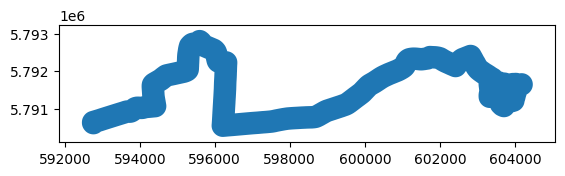

In [35]:
gdf_line_buffers[gdf_line_buffers["LINENAME"] == "34_450"].plot()

In [36]:
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from typing import Union, Optional

def filter_od_in_line_buffers(
    gdf_origin: gpd.GeoDataFrame,
    gdf_line_buffers: gpd.GeoDataFrame,
    *,
    origin_geom_col: str = "origin_geometry",     # column in gdf_origin with origin point geometry
    dest_geom_col: str = "destination_geometry",  # column in gdf_origin with destination point geometry
    origin_id_col: Optional[str] = "origins",     # set to None if you do not have IDs
    dest_id_col: Optional[str] = "destinations",  # set to None if you do not have IDs
    predicate: str = "within",                    # "within" for points inside buffers, "intersects" if touching the edge should count
    simplify_tolerance: Optional[float] = None,   # e.g., 5.0 in projected units
    line_name: Optional[str] = None,              # filter to a single LINENAME if given
    target_crs: Union[str, int, None] = None,     # reproject all inputs before processing, e.g., 25832
    drop_same_id: bool = True,                    # drop rows where origin and destination IDs are equal
    drop_same_point: bool = False,                # drop rows where origin and destination coordinates are equal
    same_point_eps: float = 0.0                   # tolerance for same point test
) -> gpd.GeoDataFrame:
    """
    Returns rows of gdf_origin for which BOTH the origin point (origin_geom_col)
    AND the destination point (dest_geom_col) lie in at least one polygon of gdf_line_buffers.

    Only gdf_origin is required. gdf_line_buffers must have columns ["LINENAME", "geometry"].

    The function preserves all columns of gdf_origin in the output.
    """

    t0 = time.time()
    print("Start filter of OD pairs by line buffers (origin only input)")

    # 0. Basic checks
    if origin_geom_col not in gdf_origin or dest_geom_col not in gdf_origin:
        raise KeyError("origin_geom_col or dest_geom_col not found in gdf_origin")

    # 1. CRS handling
    go = gpd.GeoDataFrame(gdf_origin.copy(), geometry=gdf_origin[origin_geom_col], crs=gdf_origin.crs)
    gd = gpd.GeoDataFrame(gdf_origin.copy(), geometry=gdf_origin[dest_geom_col],   crs=gdf_origin.crs)
    gb = gdf_line_buffers[["LINENAME", "geometry"]].copy()

    if target_crs is not None:
        print(f"Reproject all layers to CRS {target_crs}")
        go = go.to_crs(target_crs)
        gd = gd.to_crs(target_crs)
        gb = gb.to_crs(target_crs)
    else:
        if not (go.crs == gd.crs == gb.crs):
            raise ValueError("CRS mismatch. Set target_crs or align CRS before calling this function.")

    # (2.) Optional filter to one LINENAME
    if line_name is not None:
        print(f"Restrict buffers to LINENAME == {line_name}")
        gb = gb.loc[gb["LINENAME"] == line_name]
        if gb.empty:
            print("No buffers for requested LINENAME. Returning empty result.")
            return go.iloc[[]].copy()

    # 3. Optional simplify of buffers to speed up polygon tests
    if simplify_tolerance is not None and simplify_tolerance > 0:
        print(f"Simplify buffer geometries with tolerance {simplify_tolerance}")
        gb = gb.set_geometry(gb.geometry.simplify(simplify_tolerance, preserve_topology=True))

    print(f"Buffers count: {len(gb)}")
    print(f"Origin rows before filtering: {len(go)}")

    # 4. Drop rows with same origin and destination ID
    if drop_same_id and origin_id_col is not None and dest_id_col is not None:
        if origin_id_col not in go or dest_id_col not in go:
            print("ID columns not found. Skipping drop_same_id.")
        else:
            id_mask = go[origin_id_col] != go[dest_id_col]
            dropped = int((~id_mask).sum())
            if dropped > 0:
                print(f"Dropping {dropped} rows where origin and destination IDs are equal")
                go = go.loc[id_mask]
                gd = gd.loc[go.index]

    # (5) Optional drop rows with same origin and destination coordinates
    if drop_same_point:
        ox = go.geometry.x.to_numpy()
        oy = go.geometry.y.to_numpy()
        dx = gd.geometry.x.reindex(go.index).to_numpy()
        dy = gd.geometry.y.reindex(go.index).to_numpy()
        valid = np.isfinite(ox) & np.isfinite(oy) & np.isfinite(dx) & np.isfinite(dy)
        if same_point_eps > 0.0:
            same = valid & (np.abs(ox - dx) <= same_point_eps) & (np.abs(oy - dy) <= same_point_eps)
        else:
            same = valid & (ox == dx) & (oy == dy)
        n_same = int(same.sum())
        if n_same > 0:
            print(f"Dropping {n_same} rows where origin and destination points are identical")
            keep_mask = ~same
            go = go.loc[keep_mask]
            gd = gd.loc[go.index]

    # 6 Fast bounding box prefilter on both origin and destination points
    bxmin, bymin, bxmax, bymax = gb.total_bounds
    bbox_poly = box(bxmin, bymin, bxmax, bymax)

    mask_o_bbox = go.geometry.within(bbox_poly)
    mask_d_bbox = gd.geometry.within(bbox_poly)

    go_pref = go.loc[mask_o_bbox]
    gd_pref = gd.loc[mask_d_bbox]

    print(f"Origins prefilter kept {len(go_pref)} of {len(go)}")
    print(f"Destinations prefilter kept {len(gd_pref)} of {len(gd)}")

    # 7. Spatial joins: origin and destination must each match any buffer
    t1 = time.time()
    print(f"Spatial join origins with predicate '{predicate}'")
    o_join = gpd.sjoin(go_pref, gb, how="inner", predicate=predicate)
    origin_hits = np.unique(o_join.index.values)
    print(f"Origins matched buffers: {len(origin_hits)}")

    print(f"Spatial join destinations with predicate '{predicate}'")
    d_join = gpd.sjoin(gd_pref, gb, how="inner", predicate=predicate)
    dest_hits = np.unique(d_join.index.values)
    print(f"Destinations matched buffers: {len(dest_hits)}")
    t2 = time.time()

    # 8. Combine masks on the full index space of gdf_origin
    origin_hit_idx = pd.Index(origin_hits)
    dest_hit_idx = pd.Index(dest_hits)

    good_idx = origin_hit_idx.intersection(dest_hit_idx)
    # Make sure we only take rows that still exist in go after any filtering
    good_idx = good_idx.intersection(go.index)

    gdf_filtered = gdf_origin.loc[good_idx].copy()

    # 9. Report
    dt_total = time.time() - t0
    dt_joins = t2 - t1
    print(f"Final filtered rows: {len(gdf_filtered)}")
    print(f"Time spatial joins: {dt_joins:,.2f}s   Total time: {dt_total:,.2f}s")

    return gdf_filtered

# Usageful example:
gdf_filtered_all = filter_od_in_line_buffers(
    gdf_origin=gdf_origin,
    gdf_line_buffers=gdf_line_buffers,
    origin_geom_col="origin_geometry",
    dest_geom_col="destination_geometry",
    origin_id_col="origins",
    dest_id_col="destinations",
    predicate="intersects",
    simplify_tolerance=None,
    line_name=None,
    drop_same_id=True,
    drop_same_point=False,
    same_point_eps=0.0
)


Start filter of OD pairs by line buffers (origin only input)
Buffers count: 35
Origin rows before filtering: 4752400
Dropping 2180 rows where origin and destination IDs are equal
Origins prefilter kept 2133241 of 4750220
Destinations prefilter kept 2133241 of 4750220
Spatial join origins with predicate 'intersects'
Origins matched buffers: 1316116
Spatial join destinations with predicate 'intersects'
Destinations matched buffers: 1316116
Final filtered rows: 364212
Time spatial joins: 259.85s   Total time: 283.19s


## 7. Intersections and coverage (origins/destinations)

Intersect buffers with origin/destination zones. Count unique zones by ID and by geometry to avoid inflated counts from duplicates.

In [37]:
# Filter gdf_filtered_all into gdf_close_to_regio_bus_line using the requested thresholds
import pandas as pd
import geopandas as gpd

assert 'gdf_filtered_all' in globals() and isinstance(gdf_filtered_all, (pd.DataFrame, gpd.GeoDataFrame)), \
    "gdf_filtered_all not found; run the steps producing it first."

need = ['usage_rebus', 'pt_transfers', 'pt_trips']
missing = [c for c in need if c not in gdf_filtered_all.columns]
if missing:
    raise KeyError(f"gdf_filtered_all is missing required columns: {missing}")

mask = (
    (gdf_filtered_all['usage_rebus'] > 0.01) &
    (gdf_filtered_all['pt_transfers'] < 2) &
    (gdf_filtered_all['pt_trips'] > 5)
)

pre = len(gdf_filtered_all)
gdf_close_to_regio_bus_line = gdf_filtered_all.loc[mask].copy()
post = len(gdf_close_to_regio_bus_line)
print(f"gdf_close_to_regio_bus_line created from gdf_filtered_all: {post} rows (from {pre})")

gdf_close_to_regio_bus_line created from gdf_filtered_all: 3802 rows (from 364212)


In [38]:
import pandas as pd
import geopandas as gpd

# Config: set your key column names here
KEY_ORIGIN = "origins"
KEY_DEST   = "destinations"

# 1) Ensure keys exist and de-duplicate both sources on OD keys
def _prep_keys(df: pd.DataFrame, o=KEY_ORIGIN, d=KEY_DEST) -> pd.DataFrame:
    if o not in df.columns or d not in df.columns:
        raise KeyError(f"Missing key columns '{o}' or '{d}'")
    # cast to string to avoid type-mismatch on merge
    out = df.copy()
    out[o] = out[o].astype(str)
    out[d] = out[d].astype(str)
    return out.drop_duplicates(subset=[o, d], keep="first")

df_usage_filtered = _prep_keys(df_usage_filtered)
gdf_close_to_regio_bus_line = _prep_keys(gdf_close_to_regio_bus_line)

# 2) Find OD keys present in "close_to_bus" but missing in "usage_filtered"
usage_keys = set(zip(df_usage_filtered[KEY_ORIGIN], df_usage_filtered[KEY_DEST]))
close_keys = set(zip(gdf_close_to_regio_bus_line[KEY_ORIGIN], gdf_close_to_regio_bus_line[KEY_DEST]))

missing_keys = close_keys.difference(usage_keys)
print(f"Missing OD keys to add: {len(missing_keys)}")

# 3) Extract only the missing rows from gdf_close_to_regio_bus_line
if missing_keys:
    mk_origin, mk_dest = zip(*missing_keys)  # tuples -> two lists
    mask_missing = (
        gdf_close_to_regio_bus_line[KEY_ORIGIN].isin(mk_origin)
        & gdf_close_to_regio_bus_line[KEY_DEST].isin(mk_dest)
    )
    new_rows_full = gdf_close_to_regio_bus_line.loc[mask_missing].copy()
else:
    new_rows_full = gdf_close_to_regio_bus_line.iloc[0:0].copy()  # empty same-structure

# 4) Align columns: take intersection so concat is clean
common_cols = [c for c in df_usage_filtered.columns if c in new_rows_full.columns]
new_rows = new_rows_full[common_cols].copy()

# 5) Concatenate; preserve GeoDataFrame if df_usage_filtered is GeoDataFrame
if isinstance(df_usage_filtered, gpd.GeoDataFrame):
    # If both have same CRS and geometry name, GeoPandas will keep geometry
    df_routing = pd.concat([df_usage_filtered, new_rows], ignore_index=False)
    df_routing = gpd.GeoDataFrame(df_routing, geometry=df_usage_filtered.geometry.name, crs=df_usage_filtered.crs)
else:
    df_routing = pd.concat([df_usage_filtered, new_rows], ignore_index=False)

print(f"Original df_usage_filtered: {len(df_usage_filtered)} rows")
print(f"Added new rows: {len(new_rows)}")
print(f"Updated DataFrame: {len(df_routing)} rows")

df_routing = df_routing[df_routing["usage_rebus"] >= 0.05]
print(f"After filtering usage_rebus: {len(df_routing)} rows")
# 6) Reset index for clean sequential numbering
df_routing_reset = df_routing.reset_index(drop=True)


Missing OD keys to add: 861
Original df_usage_filtered: 3226 rows
Added new rows: 2124
Updated DataFrame: 5350 rows
After filtering usage_rebus: 4853 rows


<Axes: >

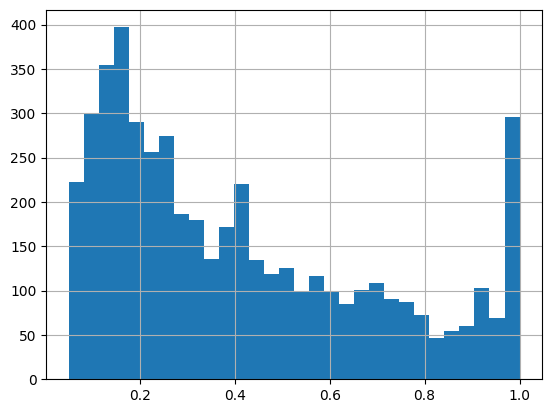

In [39]:
df_routing_reset["usage_rebus"].hist(bins=30)

### Enrich `df_routing` with connector endpoints and counts per origin/destination

Match each OD pair to its origin and destination zones from `zones_with_endpoints` and add:
- `connector_far_endpoints_origin`, `connector_far_endpoints_destination`
- `n_connectors_o`, `n_connectors_d`

In [40]:
# Join zones_with_endpoints to df_routing for origin and destination to add endpoint lists and connector counts
import pandas as pd
import geopandas as gpd

# Preconditions
assert 'df_routing' in globals() and not df_routing.empty, "df_routing missing; build routing table first."
assert 'zones_with_endpoints' in globals() and not zones_with_endpoints.empty, "zones_with_endpoints missing; compute it earlier."

# Resolve key columns
orig_col = ORIGIN_COL if 'ORIGIN_COL' in globals() and ORIGIN_COL in df_routing_reset.columns else 'origins'
dest_col = DEST_COL if 'DEST_COL' in globals() and DEST_COL in df_routing_reset.columns else 'destinations'
zone_id_col = 'NO' if 'NO' in zones_with_endpoints.columns else (KEY_ORIGIN if 'KEY_ORIGIN' in globals() else zones_with_endpoints.columns[0])

# Determine endpoint + count columns available in zones_with_endpoints
endpoints_col = 'connector_far_endpoints' if 'connector_far_endpoints' in zones_with_endpoints.columns else None
n_connectors_col = 'n_connectors' if 'n_connectors' in zones_with_endpoints.columns else None
if endpoints_col is None:
    raise KeyError("zones_with_endpoints must contain 'connector_far_endpoints'.")
if n_connectors_col is None:
    raise KeyError("zones_with_endpoints must contain 'n_connectors'.")

# Harmonize key dtypes: cast routing keys and zone ids to string to avoid object/int64 mismatches
df_routing_reset = df_routing_reset.copy()
df_routing_reset[orig_col] = df_routing_reset[orig_col].astype(str)
df_routing_reset[dest_col] = df_routing_reset[dest_col].astype(str)

zones_slim_base = zones_with_endpoints[[zone_id_col, endpoints_col, n_connectors_col]].copy()

# Build origin side mapping
zones_slim_o = zones_slim_base.rename(columns={
    endpoints_col: 'connector_far_endpoints_o',
    n_connectors_col: 'n_connectors_o'
}).copy()
zones_slim_o['zone_id_key_o'] = zones_slim_o[zone_id_col].astype(str)

# Build destination side mapping
zones_slim_d = zones_slim_base.rename(columns={
    endpoints_col: 'connector_far_endpoints_d',
    n_connectors_col: 'n_connectors_d'
}).copy()
zones_slim_d['zone_id_key_d'] = zones_slim_d[zone_id_col].astype(str)

# Origin join (explicit right_on to avoid dtype mismatch)
left = df_routing.merge(
    zones_slim_o[['zone_id_key_o', 'connector_far_endpoints_o', 'n_connectors_o']],
    left_on=orig_col,
    right_on='zone_id_key_o',
    how='left'
).drop(columns=['zone_id_key_o'])

# Destination join (use separate key column to avoid collision)
left = left.merge(
    zones_slim_d[['zone_id_key_d', 'connector_far_endpoints_d', 'n_connectors_d']],
    left_on=dest_col,
    right_on='zone_id_key_d',
    how='left'
).drop(columns=['zone_id_key_d'])

# Fill missing counts with zero and ensure ints
left['n_connectors_o'] = left['n_connectors_o'].fillna(0).astype(int)
left['n_connectors_d'] = left['n_connectors_d'].fillna(0).astype(int)

# Update df_routing
df_routing_reset = left
df_routing_OD = df_routing_reset.copy()

print("df_routing enriched with: connector_far_endpoints_o/_d and n_connectors_o/_d")
df_routing_OD

df_routing enriched with: connector_far_endpoints_o/_d and n_connectors_o/_d


,origins,destinations,usage_rebus,pt_transfers,pt_trips,origin_name,destination_name,origin_geometry,destination_geometry,connector_far_endpoints_o,n_connectors_o,connector_far_endpoints_d,n_connectors_d
0,310101901,310101902,0.199772,0.002856,22.912864,BS Stadtkern 6,BS Stadtkern 9,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603798.46 5791316.225, 603740.225 57...","[POINT (603753.1947001892 5791660.670899331), ...",8,"[POINT (604042.8107924324 5791528.604788725), ...",4
1,310101901,310101903,0.176499,0.020194,21.427874,BS Stadtkern 6,BS Stadtkern 13,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603829.121 5790964.967, 603769.226 5...","[POINT (603753.1947001892 5791660.670899331), ...",8,"[POINT (604018.5991001911 5791116.588899326), ...",8
2,310101901,310101905,0.160468,0.002142,26.381425,BS Stadtkern 6,BS Stadtkern 15,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603968.386 5791312.927, 603981.628 5...","[POINT (603753.1947001892 5791660.670899331), ...",8,[POINT (603697.1937001882 5791271.173799336)],1
3,310101901,310101906,0.126761,0.001530,7.532319,BS Stadtkern 6,BS Stadtkern 19,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603337.316 5791321.653, 603337.282 5...","[POINT (603753.1947001892 5791660.670899331), ...",8,"[POINT (603589.7528001876 5791185.471099338), ...",5
4,310101901,310101907,0.122328,0.000000,12.952408,BS Stadtkern 6,BS Stadtkern 1,"POLYGON ((603845.77 5791532.412, 603828.391 57...","POLYGON ((603337.282 5791322.202, 603334.507 5...","[POINT (603753.1947001892 5791660.670899331), ...",8,"[POINT (603411.6038001857 5791542.245599344), ...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,315803730,315803712,0.758223,0.000000,17.256473,WB Weisse Schanze 30,WB Heinrichstadt 12,"POLYGON ((604214.359 5780230.728, 604363.133 5...","POLYGON ((605660.872 5780293.601, 605665.925 5...","[POINT (604340.0656001947 5779700.757699319), ...",6,[POINT (605266.4475002037 5780032.981699282)],1
4849,315803730,315803716,0.760112,0.000509,44.216752,WB Weisse Schanze 30,WB Krz Holz 16,"POLYGON ((604214.359 5780230.728, 604363.133 5...","POLYGON ((605170.562 5783478.749, 605166.451 5...","[POINT (604340.0656001947 5779700.757699319), ...",6,[POINT (606022.3235002109 5782061.893699247)],1
4850,315803730,315803718,0.079595,0.000000,8.126527,WB Weisse Schanze 30,WB Krz Holz 18,"POLYGON ((604214.359 5780230.728, 604363.133 5...","POLYGON ((606628.196 5781385.112, 606580.824 5...","[POINT (604340.0656001947 5779700.757699319), ...",6,"[POINT (606916.9989002203 5781523.65459921), P...",5
4851,315803730,315803720,0.420622,0.486363,16.467809,WB Weisse Schanze 30,WB Linden 20,"POLYGON ((604214.359 5780230.728, 604363.133 5...","POLYGON ((608059.761 5778529.1, 608059.637 577...","[POINT (604340.0656001947 5779700.757699319), ...",6,[POINT (607141.5890002229 5778471.983599201)],1


In [41]:
from shapely.geometry import MultiPoint, Point
from shapely import wkt
import pandas as pd
from shapely.wkb import dumps as wkb_dumps

ENDPOINT_COLS = ["connector_far_endpoints_o", "connector_far_endpoints_d"]

def _pack_points(pts):
    if not pts: return None
    valid = [p for p in pts if isinstance(p, Point)]
    return MultiPoint(valid).wkt if valid else None

def _geom_to_wkb(g):
    return wkb_dumps(g, hex=True) if g is not None else None

# Pack endpoints to WKT
df_packed = df_routing_OD.copy()
for col in ENDPOINT_COLS:
    if col in df_packed:
        df_packed[col + "_wkt"] = df_packed[col].apply(_pack_points)
        df_packed = df_packed.drop(columns=[col])

# Convert geometry columns to WKB
for col in [c for c in df_packed.columns if str(df_packed[c].dtype) == "geometry"]:
    df_packed[col + "_wkb"] = df_packed[col].apply(_geom_to_wkb)
    df_packed = df_packed.drop(columns=[col])

# Export
df_routing_OD.to_csv(output_dir / "df_routing_OD.csv", index=False)
df_packed.to_parquet(output_dir / "df_routing_OD.parquet", index=False)
print("Export done:", len(df_packed), "rows")


Export done: 4853 rows


In [51]:
from shapely import wkt, from_wkb

# ==== IMPORT-TEST ====
df_routing_OD = pd.read_parquet(output_dir / "df_routing_OD.parquet")

# Restore endpoints
for col in ["connector_far_endpoints_o", "connector_far_endpoints_d"]:
    wkt_col = col + "_wkt"
    if wkt_col in df_routing_OD:
        df_routing_OD[col] = df_routing_OD[wkt_col].apply(
            lambda s: list(wkt.loads(s).geoms) if s else []
        )

# Restore geometry
for col in [c for c in df_routing_OD.columns if c.endswith("_wkb")]:
    orig = col.replace("_wkb", "")
    df_routing_OD[orig] = df_routing_OD[col].apply(
        lambda s: from_wkb(bytes.fromhex(s)) if pd.notna(s) else None
    )

print("Reloaded rows:", len(df_routing_OD))

Reloaded rows: 4853


## OD Pair Expansion & Time-Slice Schedule (Consolidated Utility)

The following cells provide a single high-level function `prepare_routing_schedule` that:

1. Expands OD metadata rows (with MultiPoint WKT endpoint columns) into individual endpoint pair rows.
2. Validates that the expanded count matches the theoretical product sum over connectors.
3. Generates departure time slices for a given date/time window & interval.
4. Creates a Cartesian product (pairs × slices) schedule DataFrame.
5. Saves (optional) intermediate and final outputs to the scenario output directory.

Parameters let you control:
- Date / start & end hour / interval minutes.
- Column names for origin/destination endpoint WKT.
- Which columns from the original OD meta table to retain.
- Output directory and file naming.

The logic mirrors the earlier notebook cells but is now wrapped in reusable, well-documented functions.

In [53]:
from __future__ import annotations
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Sequence
from shapely import wkt
from shapely.geometry import Point
from datetime import datetime, timedelta, timezone

# Optional CRS transform support (ETRS89 / UTM32N -> WGS84)
try:
    from pyproj import Transformer  # type: ignore
    _PYPROJ = True
except Exception:
    Transformer = None  # type: ignore
    _PYPROJ = False

# -----------------------------
# Low-level geometry utilities
# -----------------------------

def _unpack_multipoint(wkt_str: str | None):
    if not wkt_str or pd.isna(wkt_str):
        return []
    try:
        geom = wkt.loads(wkt_str)
    except Exception:
        return []
    if isinstance(geom, Point):
        return [geom]
    geoms = getattr(geom, 'geoms', None)
    if geoms is not None:
        return [g for g in geoms if isinstance(g, Point)]
    return []

# -----------------------------
# Expansion of OD meta
# -----------------------------

def expand_od_meta(
    df: pd.DataFrame,
    origin_wkt_col: str = 'connector_far_endpoints_o_wkt',
    dest_wkt_col: str = 'connector_far_endpoints_d_wkt',
    relation_id_col: str = 'relation_id',
    keep_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    if keep_cols is None:
        keep_cols = [
            relation_id_col,
            'origins','destinations','origin_name','destination_name',
            'usage_rebus','pt_transfers','pt_trips'
        ]
    present_keep = [c for c in keep_cols if c in df.columns]
    rows: List[dict] = []
    for base_row_id, row in df.iterrows():
        o_pts = _unpack_multipoint(row.get(origin_wkt_col))
        d_pts = _unpack_multipoint(row.get(dest_wkt_col))
        if not o_pts or not d_pts:
            continue
        base_meta = {c: row.get(c) for c in present_keep}
        base_meta['row_id'] = base_row_id
        base_meta['n_connectors_o'] = len(o_pts)
        base_meta['n_connectors_d'] = len(d_pts)
        for oi, op in enumerate(o_pts):
            for di, dp in enumerate(d_pts):
                rows.append({
                    **base_meta,
                    'origin_endpoint_index': oi,
                    'destination_endpoint_index': di,
                    'origin_lon': op.x,
                    'origin_lat': op.y,
                    'dest_lon': dp.x,
                    'dest_lat': dp.y,
                })
    if not rows:
        return pd.DataFrame(columns=[
            'od_index','pair_id','row_id','origin_endpoint_index','destination_endpoint_index',
            'origin_lat','origin_lon','dest_lat','dest_lon'
        ] + present_keep + ['n_connectors_o','n_connectors_d'])
    expanded = pd.DataFrame(rows).reset_index(drop=True)
    expanded['od_index'] = range(len(expanded))
    def _mk_id(r):
        rel = r.get(relation_id_col)
        if relation_id_col in expanded.columns and pd.notna(rel):
            return f"REL_{rel}__O{int(r.origin_endpoint_index)+1}_D{int(r.destination_endpoint_index)+1}"
        return f"ROW_{int(r.row_id)}_O{int(r.origin_endpoint_index)+1}_D{int(r.destination_endpoint_index)+1}"
    expanded['pair_id'] = expanded.apply(_mk_id, axis=1)
    first_cols = [
        'od_index','pair_id',
        relation_id_col if relation_id_col in expanded.columns else None,
        'row_id','origin_endpoint_index','destination_endpoint_index',
        'origin_lat','origin_lon','dest_lat','dest_lon','n_connectors_o','n_connectors_d'
    ]
    first_cols = [c for c in first_cols if c in expanded.columns]
    other = [c for c in expanded.columns if c not in first_cols]
    return expanded[first_cols + other]

# -----------------------------
# Validation helpers
# -----------------------------

def compute_expected_pair_count(df: pd.DataFrame,
                                origin_wkt_col: str = 'connector_far_endpoints_o_wkt',
                                dest_wkt_col: str = 'connector_far_endpoints_d_wkt') -> pd.DataFrame:
    def _count_points(wkt_str):
        pts = _unpack_multipoint(wkt_str)
        return len(pts)
    out = df.copy()
    if 'n_connectors_o' not in out.columns:
        out['n_connectors_o'] = out[origin_wkt_col].map(_count_points)
    if 'n_connectors_d' not in out.columns:
        out['n_connectors_d'] = out[dest_wkt_col].map(_count_points)
    out['expected_pairs_row'] = out['n_connectors_o'] * out['n_connectors_d']
    return out

# -----------------------------
# Time slice generation
# -----------------------------

def build_time_slices(date_iso: str, start_hour: int, end_hour: int, interval_minutes: int) -> List[str]:
    date_part = date_iso.split('T')[0]
    start_dt = datetime.fromisoformat(f"{date_part}T{start_hour:02d}:00:00+00:00")
    end_dt = datetime.fromisoformat(f"{date_part}T{end_hour:02d}:00:00+00:00")
    cur = start_dt
    out: List[str] = []
    step = max(1, int(interval_minutes))
    while cur <= end_dt:
        out.append(cur.astimezone(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ'))
        cur += timedelta(minutes=step)
    return out

# -----------------------------
# CRS transformation helper
# -----------------------------

def transform_pairs_to_wgs(df: pd.DataFrame, src_epsg: str = 'EPSG:25832') -> pd.DataFrame:
    """Return copy with *_lon_wgs84 / *_lat_wgs84 columns (origin/dest) if pyproj is available."""
    if df.empty or not _PYPROJ:
        return df.copy()
    try:
        transformer = Transformer.from_crs(src_epsg, 'EPSG:4326', always_xy=True)
    except Exception:
        return df.copy()
    out = df.copy()
    if {'origin_lon','origin_lat','dest_lon','dest_lat'} - set(out.columns):
        return out
    o_lon_wgs, o_lat_wgs = transformer.transform(out['origin_lon'].values, out['origin_lat'].values)
    d_lon_wgs, d_lat_wgs = transformer.transform(out['dest_lon'].values, out['dest_lat'].values)
    out['origin_lon_wgs84'] = o_lon_wgs
    out['origin_lat_wgs84'] = o_lat_wgs
    out['dest_lon_wgs84'] = d_lon_wgs
    out['dest_lat_wgs84'] = d_lat_wgs
    return out

# -----------------------------
# Main orchestration dataclass
# -----------------------------

@dataclass
class RoutingPreparationConfig:
    date: str = '2025-05-13'
    start_hour: int = 6
    end_hour: int = 22
    interval_minutes: int = 15
    origin_wkt_col: str = 'connector_far_endpoints_o_wkt'
    dest_wkt_col: str = 'connector_far_endpoints_d_wkt'
    relation_id_col: str = 'relation_id'
    keep_cols: Optional[List[str]] = None
    output_dir: Optional[Path] = None
    save_prefix: str = 'od_meta'
    save_expanded: bool = True
    save_schedule: bool = True
    save_expanded_csv: bool = True
    save_schedule_csv: bool = True
    transform_to_wgs84: bool = True          # NEW: default yes
    src_epsg: str = 'EPSG:25832'             # Source CRS for numeric coords
    save_transformed: bool = True            # save transformed copies

@dataclass
class RoutingPreparationResult:
    expanded_pairs: pd.DataFrame
    schedule: pd.DataFrame
    time_slices: List[str]
    expected_pair_total: int
    pairs_match: bool
    expanded_pairs_wgs: Optional[pd.DataFrame]
    schedule_wgs: Optional[pd.DataFrame]

# -----------------------------
# High-level orchestration
# -----------------------------

def prepare_routing_schedule(od_meta: pd.DataFrame, cfg: RoutingPreparationConfig) -> RoutingPreparationResult:
    expanded = expand_od_meta(
        od_meta,
        origin_wkt_col=cfg.origin_wkt_col,
        dest_wkt_col=cfg.dest_wkt_col,
        relation_id_col=cfg.relation_id_col,
        keep_cols=cfg.keep_cols,
    )
    enriched_counts = compute_expected_pair_count(od_meta,
                                                  origin_wkt_col=cfg.origin_wkt_col,
                                                  dest_wkt_col=cfg.dest_wkt_col)
    expected_total = int(enriched_counts['expected_pairs_row'].sum())
    expanded_total = int(len(expanded))
    pairs_match = (expected_total == expanded_total)
    time_slices = build_time_slices(cfg.date, cfg.start_hour, cfg.end_hour, cfg.interval_minutes)
    schedule = (
        expanded.assign(_k=1)
        .merge(pd.DataFrame({'departure_time': time_slices, '_k': 1}), on='_k')
        .drop(columns=['_k'])
    )
    expanded_wgs: Optional[pd.DataFrame] = None
    schedule_wgs: Optional[pd.DataFrame] = None
    if cfg.transform_to_wgs84:
        expanded_wgs = transform_pairs_to_wgs(expanded, src_epsg=cfg.src_epsg)
        schedule_wgs = transform_pairs_to_wgs(schedule, src_epsg=cfg.src_epsg)

    if cfg.output_dir is not None:
        cfg.output_dir.mkdir(parents=True, exist_ok=True)
        if cfg.save_expanded:
            p_path = cfg.output_dir / f"{cfg.save_prefix}_expanded.parquet"
            expanded.to_parquet(p_path, index=False)
            print(f"Saved expanded pairs (parquet) -> {p_path}")
            if cfg.save_expanded_csv:
                c_path = cfg.output_dir / f"{cfg.save_prefix}_expanded.csv"
                expanded.to_csv(c_path, index=False)
                print(f"Saved expanded pairs (csv)     -> {c_path}")
        if cfg.save_schedule:
            sp = cfg.output_dir / f"{cfg.save_prefix}_schedule.parquet"
            schedule.to_parquet(sp, index=False)
            print(f"Saved schedule (parquet)       -> {sp}")
            if cfg.save_schedule_csv:
                sc = cfg.output_dir / f"{cfg.save_prefix}_schedule.csv"
                schedule.to_csv(sc, index=False)
                print(f"Saved schedule (csv)          -> {sc}")
        if cfg.transform_to_wgs84 and cfg.save_transformed and expanded_wgs is not None:
            w_exp = cfg.output_dir / f"{cfg.save_prefix}_expanded_wgs84.parquet"
            expanded_wgs.to_parquet(w_exp, index=False)
            print(f"Saved expanded WGS84 (parquet) -> {w_exp}")
            if cfg.save_expanded_csv:
                w_exp_csv = cfg.output_dir / f"{cfg.save_prefix}_expanded_wgs84.csv"
                expanded_wgs.to_csv(w_exp_csv, index=False)
                print(f"Saved expanded WGS84 (csv)     -> {w_exp_csv}")
        if cfg.transform_to_wgs84 and cfg.save_transformed and schedule_wgs is not None:
            w_sch = cfg.output_dir / f"{cfg.save_prefix}_schedule_wgs84.parquet"
            schedule_wgs.to_parquet(w_sch, index=False)
            print(f"Saved schedule WGS84 (parquet) -> {w_sch}")
            if cfg.save_schedule_csv:
                w_sch_csv = cfg.output_dir / f"{cfg.save_prefix}_schedule_wgs84.csv"
                schedule_wgs.to_csv(w_sch_csv, index=False)
                print(f"Saved schedule WGS84 (csv)     -> {w_sch_csv}")

    print('\n--- Routing Preparation Summary ---')
    print('Expanded pair rows        :', expanded_total)
    print('Expected theoretical pairs:', expected_total)
    print('Counts match?             :', pairs_match)
    print('Time slices generated     :', len(time_slices))
    print('Schedule total rows       :', len(schedule))
    if cfg.transform_to_wgs84:
        print('WGS84 transform applied   :', True if expanded_wgs is not None else False)

    return RoutingPreparationResult(
        expanded_pairs=expanded,
        schedule=schedule,
        time_slices=time_slices,
        expected_pair_total=expected_total,
        pairs_match=pairs_match,
        expanded_pairs_wgs=expanded_wgs,
        schedule_wgs=schedule_wgs,
    )

print('prepare_routing_schedule() and helpers defined (with optional WGS84 transform).')

prepare_routing_schedule() and helpers defined (with optional WGS84 transform).


In [63]:
# Usage: export either only expanded pairs OR full schedule (pairs × departure_time) with WGS84 columns
# Toggle here
EXPORT_MODE = 'schedule'  # 'pairs' | 'schedule' | 'both'

try:
    _repo_root = repo_root
except NameError:
    from pathlib import Path
    _repo_root = Path.cwd()

scenario_out = _repo_root / 'output' / 'scenario_V10_2025'
scenario_out.mkdir(parents=True, exist_ok=True)

cfg = RoutingPreparationConfig(
    date='2025-05-13',
    start_hour=6,
    end_hour=22,
    interval_minutes=15,
    output_dir=None,
    save_prefix='df_routing_OD',
    save_expanded=False,
    save_schedule=False,
    save_expanded_csv=False,
    save_schedule_csv=False,
    transform_to_wgs84=True,
    save_transformed=False,
)

# Helper to build filename fragments with config info
def _cfg_tag(cfg: RoutingPreparationConfig) -> str:
    # date (YYYYMMDD), start-end hours, interval minutes
    d = cfg.date.split('T')[0].replace('-', '')  # e.g. 20250513
    hours = f"{cfg.start_hour:02d}-{cfg.end_hour:02d}"
    iv = f"{cfg.interval_minutes}m"
    return f"{d}_{hours}_{iv}"

try:
    prep_result = prepare_routing_schedule(df_routing_OD, cfg)
except NameError:
    print('Variable df_routing_OD not defined – load or create it before running this cell.')
else:
    tag = _cfg_tag(cfg)
    pairs_wgs = prep_result.expanded_pairs_wgs if prep_result.expanded_pairs_wgs is not None else transform_pairs_to_wgs(prep_result.expanded_pairs, src_epsg=cfg.src_epsg)
    schedule_wgs = prep_result.schedule_wgs if prep_result.schedule_wgs is not None else transform_pairs_to_wgs(prep_result.schedule, src_epsg=cfg.src_epsg)

    required_cols = {'origin_lon_wgs84','origin_lat_wgs84','dest_lon_wgs84','dest_lat_wgs84'}
    if required_cols - set(pairs_wgs.columns):
        raise RuntimeError('WGS84 columns missing in expanded pairs.')
    if required_cols - set(schedule_wgs.columns):
        raise RuntimeError('WGS84 columns missing in schedule.')

    exported = []
    if EXPORT_MODE in ('pairs','both'):
        out_pairs = scenario_out / f'df_routing_OD_expanded_{tag}_wgs84.parquet'
        pairs_wgs.to_parquet(out_pairs, index=False)
        exported.append(out_pairs)
    if EXPORT_MODE in ('schedule','both'):
        out_sched = scenario_out / f'df_routing_OD_schedule_{tag}_wgs84.parquet'
        schedule_wgs.to_parquet(out_sched, index=False)
        exported.append(out_sched)

    print('Exported:')
    for p in exported:
        print(' -', p.name)

    if EXPORT_MODE == 'pairs':
        display(pairs_wgs.head())
    elif EXPORT_MODE == 'schedule':
        display(schedule_wgs.head())
    else:
        print('\nExpanded pairs preview:')
        display(pairs_wgs.head())
        print('\nSchedule preview:')
        display(schedule_wgs.head())


--- Routing Preparation Summary ---
Expanded pair rows        : 66532
Expected theoretical pairs: 66532
Counts match?             : True
Time slices generated     : 65
Schedule total rows       : 4324580
WGS84 transform applied   : True
Exported:
 - df_routing_OD_schedule_20250513_06-22_15m_wgs84.parquet
Exported:
 - df_routing_OD_schedule_20250513_06-22_15m_wgs84.parquet


,od_index,pair_id,row_id,origin_endpoint_index,destination_endpoint_index,origin_lat,origin_lon,dest_lat,dest_lon,n_connectors_o,n_connectors_d,origins,destinations,origin_name,destination_name,usage_rebus,pt_transfers,pt_trips,departure_time,origin_lon_wgs84,origin_lat_wgs84,dest_lon_wgs84,dest_lat_wgs84
0,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.1947,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:00:00Z,10.52038,52.26553,10.524582,52.264288
1,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.1947,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:15:00Z,10.52038,52.26553,10.524582,52.264288
2,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.1947,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:30:00Z,10.52038,52.26553,10.524582,52.264288
3,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.1947,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:45:00Z,10.52038,52.26553,10.524582,52.264288
4,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.1947,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T07:00:00Z,10.52038,52.26553,10.524582,52.264288


In [62]:
schedule_wgs

,od_index,pair_id,row_id,origin_endpoint_index,destination_endpoint_index,origin_lat,origin_lon,dest_lat,dest_lon,n_connectors_o,n_connectors_d,origins,destinations,origin_name,destination_name,usage_rebus,pt_transfers,pt_trips,departure_time,origin_lon_wgs84,origin_lat_wgs84,dest_lon_wgs84,dest_lat_wgs84
0,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.19470,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:00:00Z,10.520380,52.265530,10.524582,52.264288
1,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.19470,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:15:00Z,10.520380,52.265530,10.524582,52.264288
2,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.19470,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:30:00Z,10.520380,52.265530,10.524582,52.264288
3,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.19470,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T06:45:00Z,10.520380,52.265530,10.524582,52.264288
4,0,ROW_0_O1_D1,0,0,0,5.791661e+06,603753.19470,5.791529e+06,604042.810792,8,4,310101901,310101902,BS Stadtkern 6,BS Stadtkern 9,0.199772,0.002856,22.912864,2025-05-13T07:00:00Z,10.520380,52.265530,10.524582,52.264288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324575,66531,ROW_4852_O6_D1,4852,5,0,5.779929e+06,604147.18966,5.778969e+06,603245.994600,6,1,315803730,315803728,WB Weisse Schanze 30,WB Weisse Schanze 28,0.092864,0.252392,18.614890,2025-05-13T21:00:00Z,10.522542,52.160022,10.509080,52.151560
4324576,66531,ROW_4852_O6_D1,4852,5,0,5.779929e+06,604147.18966,5.778969e+06,603245.994600,6,1,315803730,315803728,WB Weisse Schanze 30,WB Weisse Schanze 28,0.092864,0.252392,18.614890,2025-05-13T21:15:00Z,10.522542,52.160022,10.509080,52.151560
4324577,66531,ROW_4852_O6_D1,4852,5,0,5.779929e+06,604147.18966,5.778969e+06,603245.994600,6,1,315803730,315803728,WB Weisse Schanze 30,WB Weisse Schanze 28,0.092864,0.252392,18.614890,2025-05-13T21:30:00Z,10.522542,52.160022,10.509080,52.151560
4324578,66531,ROW_4852_O6_D1,4852,5,0,5.779929e+06,604147.18966,5.778969e+06,603245.994600,6,1,315803730,315803728,WB Weisse Schanze 30,WB Weisse Schanze 28,0.092864,0.252392,18.614890,2025-05-13T21:45:00Z,10.522542,52.160022,10.509080,52.151560
